In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

import matplotlib.pyplot as plt



import PIL

import glob
import os

from collections import defaultdict
import random
import numpy as np


    

In [2]:
def read_files(data_path):
    work_dir = os.getcwd()
    os.chdir(data_path)
    data_dict = defaultdict(dict)
    
    try:
        for file in glob.glob('./*/*'):
            path_split = file.split('/')[1:]
            data_dict[path_split[0]][path_split[1]] = os.listdir(file)
    except Exception as e:
        print(e)
        os.chdir(work_dir)
    os.chdir(work_dir)
    
    return data_dict

In [3]:
train_dir = 'app/siamese_network/data//omniglot/images_background/'
#train_dict = read_files(train_dir)

# test_dir = 'data/omniglot/images_evaluation/'
# test_dict = read_files(test_dir)

In [4]:
class ImageLoader(Dataset):
    def __init__(self, data_path, data_size, transform=None):
        self.data_path = data_path
        self.data_size = data_size
        self.transform = transform
        self.data_dict = self.read_files()
        self.category = list(self.data_dict.keys())
    
    def __len__(self):
        return self.data_size
    
    def read_files(self):
        work_dir = os.getcwd()
        os.chdir(self.data_path)
        data_dict = defaultdict(dict)

        try:
            for file in glob.glob('./*/*'):
                path_split = file.split('/')[1:]
                data_dict[path_split[0]][path_split[1]] = os.listdir(file)
        except Exception as e:
            print(e)
            os.chdir(work_dir)
        os.chdir(work_dir)

        return data_dict
    
    def sample_images(self, same_class=True):
        img1 = img2 = class_ = None
        cat = random.choice(self.category)
        if same_class:
            char = random.choice(list(self.data_dict[cat].keys()))
            img1, img2 = random.sample(self.data_dict[cat][char], 2)
            
            img1 = ('/').join([cat, char, img1])
            img2 = ('/').join([cat, char, img2])
            class_ = 1

        else:
            if random.random() > 0.5:
                char1, char2 = random.sample(list(self.data_dict[cat].keys()), 2)
                img1 = random.choice(self.data_dict[cat][char1])
                img2 = random.choice(self.data_dict[cat][char2])

                img1 = ('/').join([cat, char1, img1])
                img2 = ('/').join([cat, char2, img2])
                class_ = 0
            else:
                char1 = random.choice(list(self.data_dict[cat].keys()))
                img1 = random.choice(self.data_dict[cat][char1])
                img1 = ('/').join([cat, char1, img1])

                cat2 = random.choice(self.category)
                char2 = random.choice(list(self.data_dict[cat2].keys()))
                img2 = random.choice(self.data_dict[cat2][char2])
                img2 = ('/').join([cat2, char2, img2])
                class_= 0
        
        img1 = PIL.Image.open(self.data_path + '/' + img1)
        img2 = PIL.Image.open(self.data_path + '/' + img2)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return [img1, img2, class_]   
              
        
    
    def __getitem__(self, index):
        if index%2==0:
            return self.sample_images(same_class=True)
        return self.sample_images(same_class=False)

In [5]:
img_transform = transforms.Compose([
        transforms.Resize((255, 255)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),])

In [6]:
imgLoader = ImageLoader(train_dir, 10000, transform=img_transform)
train_set, val_set = random_split(imgLoader, [8000, 2000])

In [7]:
train_loader = DataLoader(train_set, batch_size=128)
valid_loader = DataLoader(val_set)

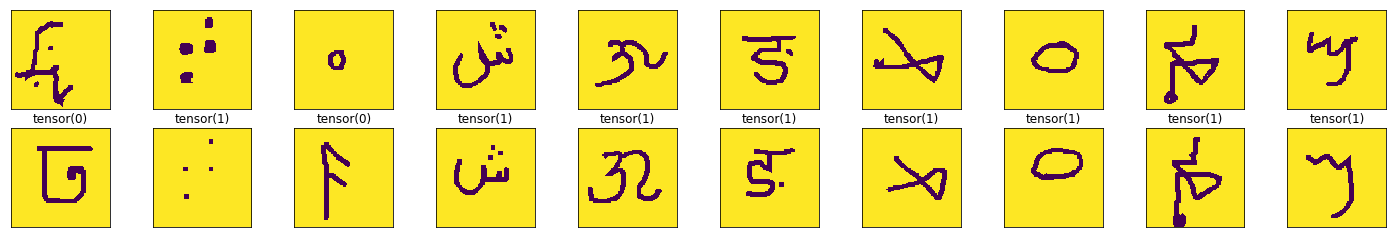

In [8]:
pair_0, pair_1, labels = next(iter(train_loader))
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax1 = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    img1 = pair_0[i].numpy().squeeze(0)
    plt.imshow(img1)
    
    ax2 = fig.add_subplot(2, 10, i+11, xticks=[], yticks=[])
    img2 = pair_1[i].numpy().squeeze(0)
    plt.imshow(img2)
    ax2.set_title(labels[i])

In [9]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        
        ###Kernals
        self.conv1 = nn.Conv2d(1,64,10)
        self.conv2 = nn.Conv2d(64,128,7)
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)

        ###Batch Norm
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        ####Dropout
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)

        ###FC layer
        self.fc1 = nn.Linear(256*6*6, 4096)
        self.fcOut = nn.Linear(4096, 1)

        ###Final output
        self.sigmoid = nn.Sigmoid()

    def convs(self, x):
        # 1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_poo2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        #128, 18, 18
        x = F.max_pool2d(x, (2,2))
        #128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        #256, 6, 6

        return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256*6*6)
        x1 = self.sigmoid(self.fc1(x1))

        x2 = self.convs(x2)
        x2 = x2.view(-1, 256*6*6)
        x2 = self.sigmoid(self.fc1(x2))

        x = torch.abs(x1-x2)
        x = self.fcOut(x)

        return x      

In [11]:
model = SiameseNet()

In [14]:
model.parameters

<bound method Module.parameters of SiameseNet(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.5)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fcOut): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train(model, train_loader, valid_loader, num_epochs, criterion):
    train_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        
        for img1, img2, labels in train_loader():
 
            # Forward pass
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = img2.to(device)

            outputs = model(img1, img2)

            # Backward and optimization
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss+=loss.item()
        
        avg_train_loss = running_loss/len(train_loader)
        train_loss.append(avg_train_loss)

        val_running_loss = 0.0

        with torch.no_grad():
            model.eval()
            for img1, img2, labels in valid_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)

                outputs = model(img1, img2)
                loss = criterion(outputs, labels)

                val_running_loss+=loss
        print(f'epoch {epoch}, train_accuracy:{avg_train_loss}  validation_accuracy:{avg_val_loss}')
        avg_val_loss = val_loss/len(valid_loader)    
        val_running_loss.append(avg_val_loss)

    return running_loss, val_running_loss       


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [18]:
train(model, train_loader, valid_loader, 2, criterion)

TypeError: 'int' object is not iterable